In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 1
commitnumber = 5014a19
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [0, 0, 0]
ng_refs = [3, 3, 6]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (30, 250), (300, 250)]
tsfc = 294
vmax = 340
vmin = 20
w_diffuse = [(1.66, 1.66, 1.66), (1.66, 1.66, 1.66), (1.66, 1.66, 1.5, 1.5, 1.5, 1.5)]
wgt = [(0.2, 0.2, 0.2), (0.2, 0.2, 0.2), (0.2, 0.2, 0.65, 0.65, 0.65, 0.65)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

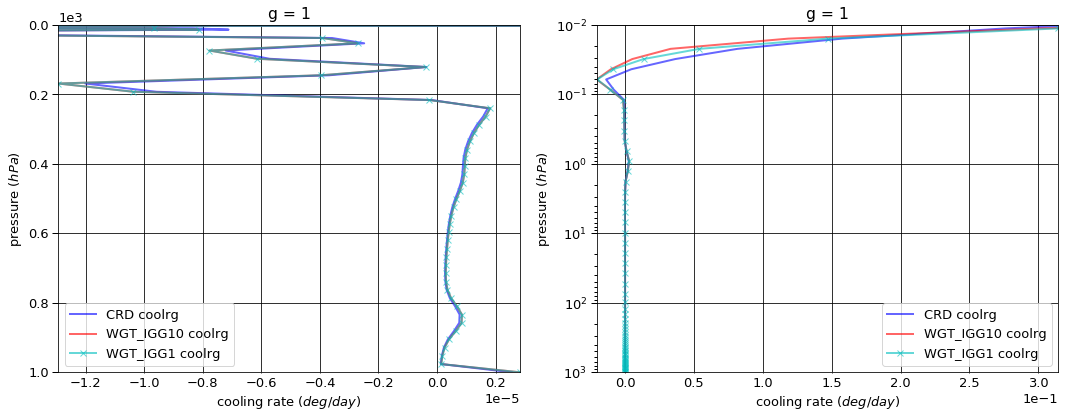

# Figure: cooling rate g-group 2

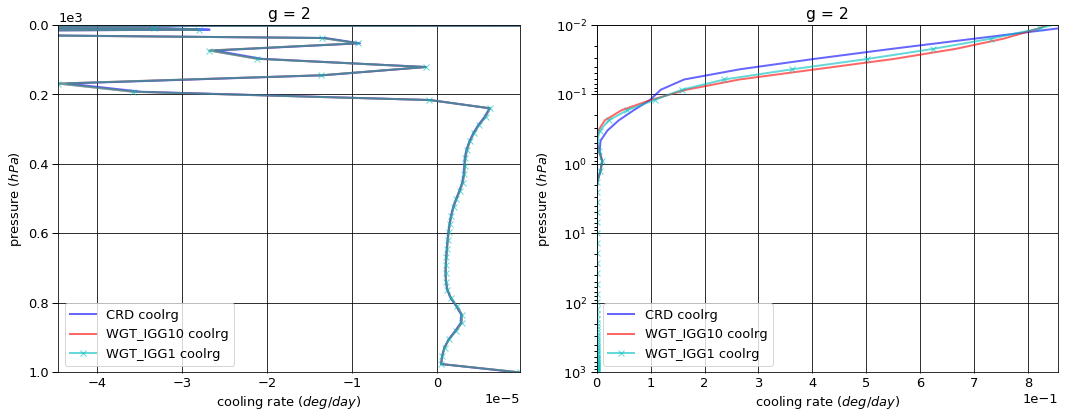

# Figure: cooling rate g-group 3

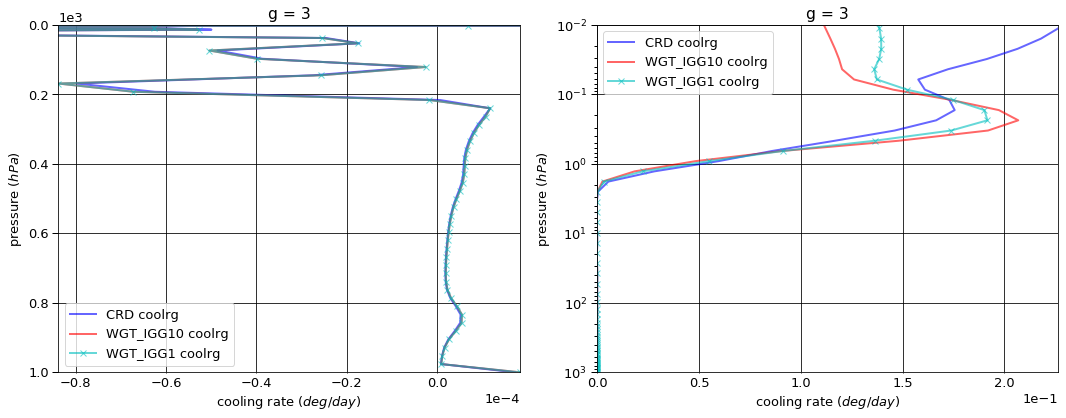

# Figure: cooling rate g-group 4

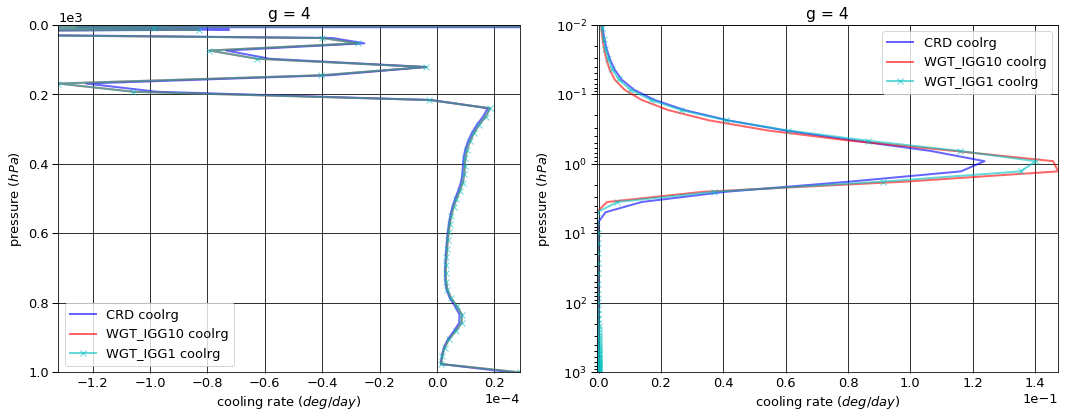

# Figure: cooling rate g-group 5

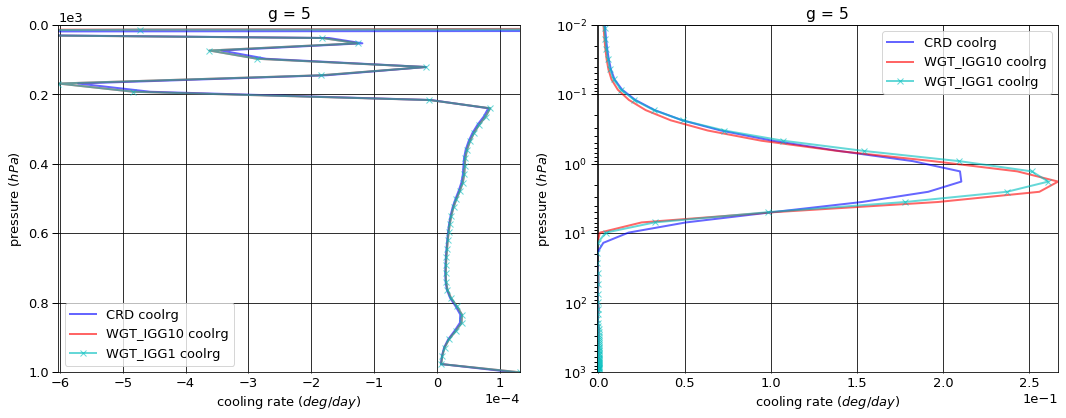

# Figure: cooling rate g-group 6

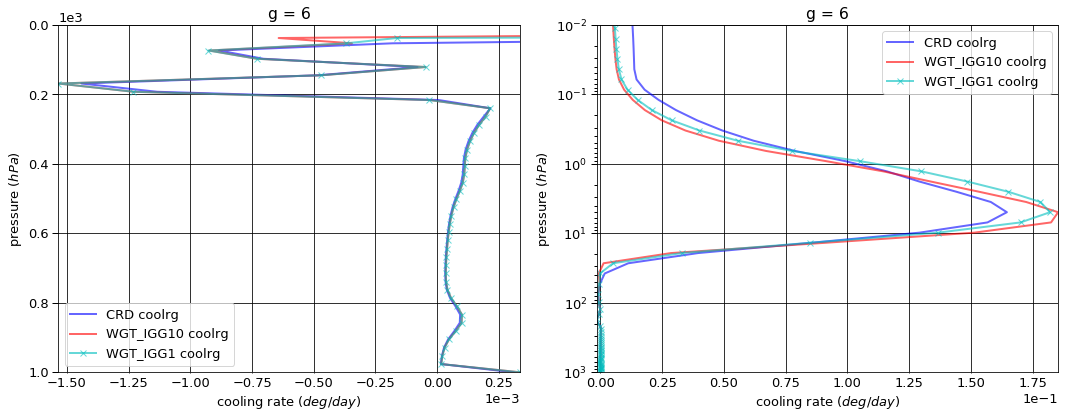

# Figure: cooling rate g-group 7

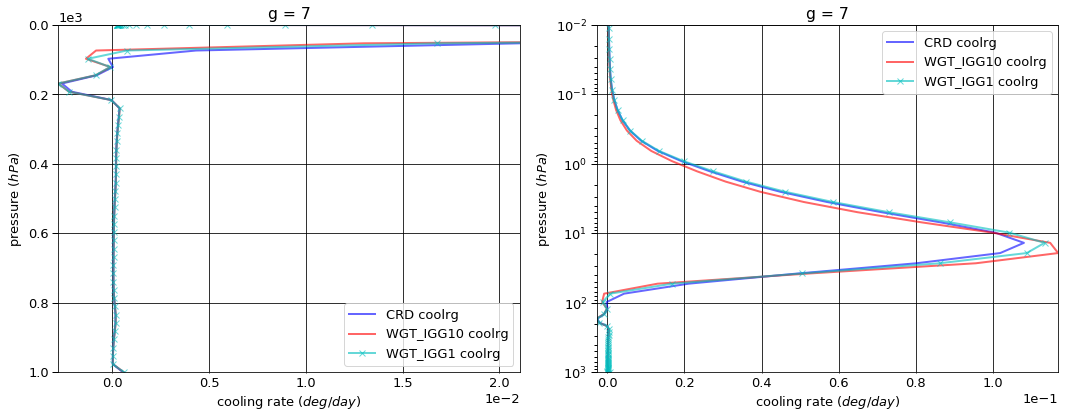

# Figure: cooling rate g-group 8

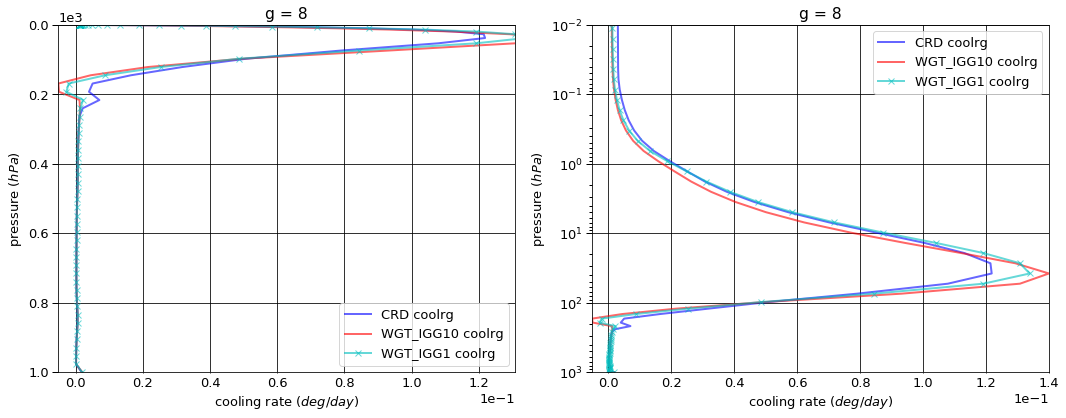

# Figure: cooling rate g-group 9

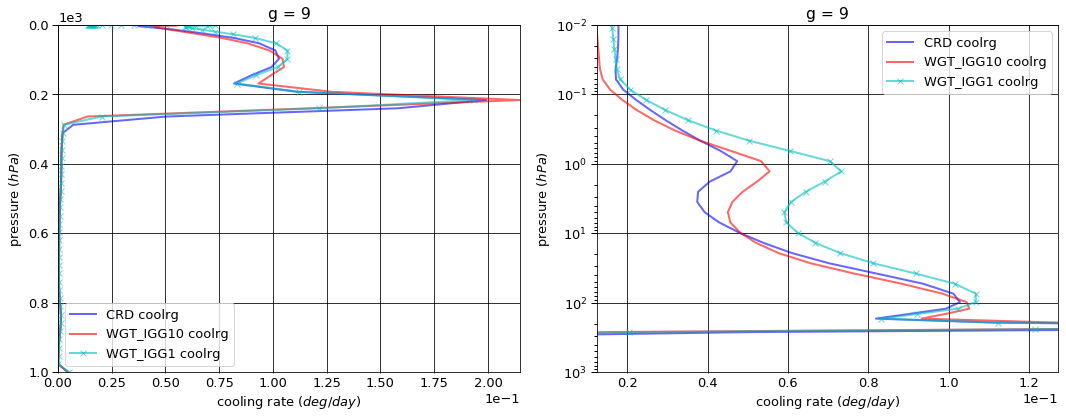

# Figure: cooling rate g-group 10

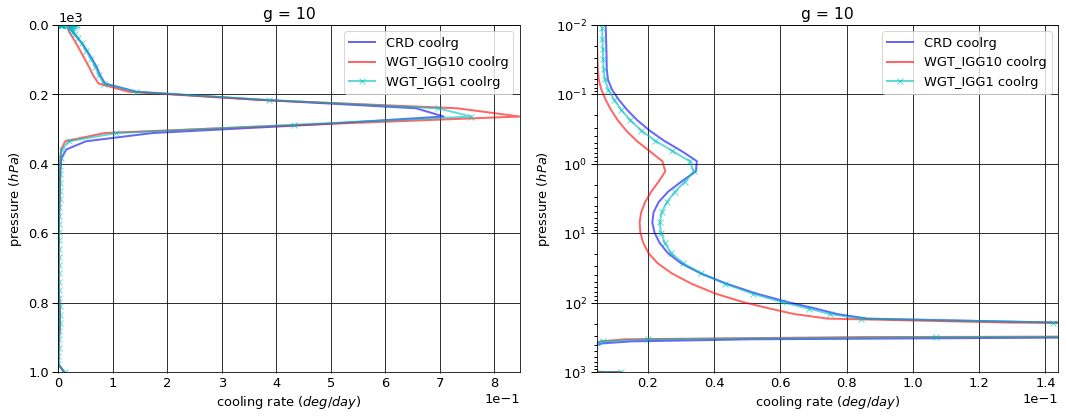

# Figure: cooling rate g-group 11

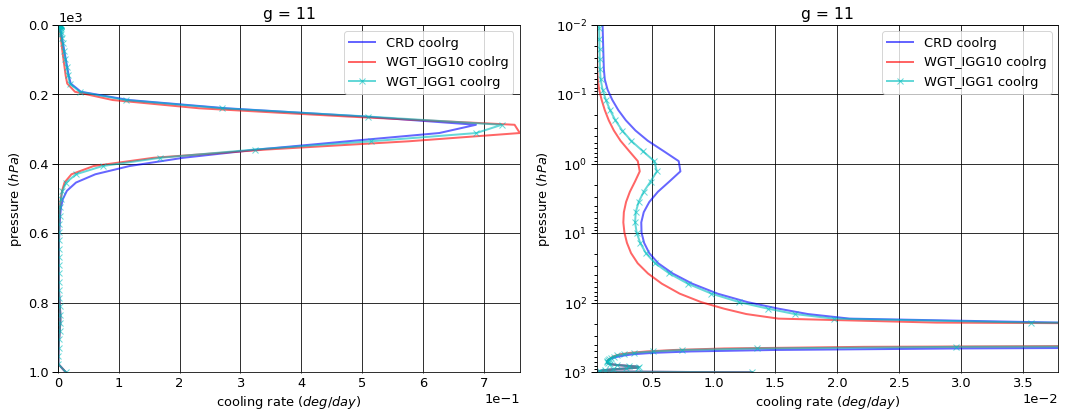

# Figure: cooling rate g-group 12

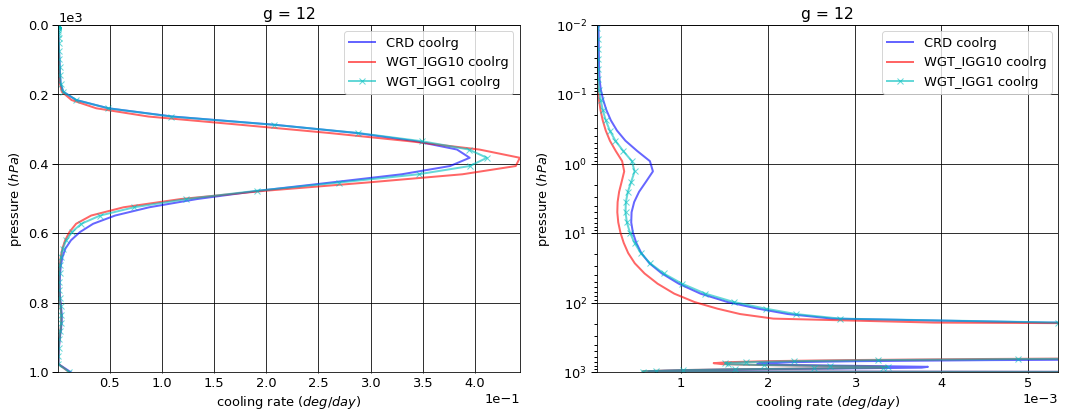

# Figure: cooling rate g-group total

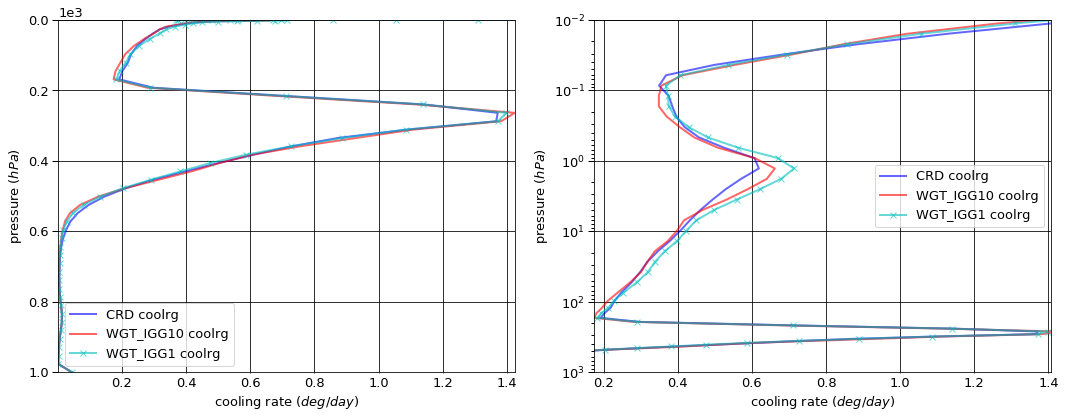

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.001832   0.000000  -0.001832
   1013.0   76     -0.003179   0.003172  -0.000007
2  0.0      1      -0.006685   0.000000  -0.006685
   1013.0   76     -0.011128   0.011102  -0.000026
3  0.0      1      -0.015281   0.000000  -0.015281
   1013.0   76     -0.020819   0.020772  -0.000048
4  0.0      1      -0.027550   0.000000  -0.027550
   1013.0   76     -0.032399   0.032327  -0.000071
5  0.0      1      -0.118895   0.000000  -0.118895
   1013.0   76     -0.149108   0.148771  -0.000337
6  0.0      1      -0.272553   0.000000  -0.272553
   1013.0   76     -0.379390   0.378537  -0.000854
7  0.0      1      -0.448097   0.000000  -0.448097
   1013.0   76     -0.686991   0.685454  -0.001537
8  0.0      1      -1.360676   0.000000  -1.360676
   1013.0   76     -2.214126   2.209174  -0.004952
9  0.0      1      -3.455744   0.000000  -3.455744
   1013.0   76     -5.628192   5.615578  -0.012613
10 0.0      1      -8.745425   0.000000  -8.745425
   1013.0   76    -13.505250  13.474653  -0.030597
11 0.0      1     -10.291928   0.000000 -10.291928
   1013.0   76    -15.101620  15.065644  -0.035975
12 0.0      1      -9.519327   0.000000  -9.519327
   1013.0   76    -13.341227  13.306175  -0.035052


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.001780   0.000000  -0.001780
   1013.0   76     -0.003254   0.003246  -0.000008
2  0.0      1      -0.006484   0.000000  -0.006484
   1013.0   76     -0.011220   0.011193  -0.000027
3  0.0      1      -0.015312   0.000000  -0.015312
   1013.0   76     -0.021106   0.021055  -0.000050
4  0.0      1      -0.028185   0.000000  -0.028185
   1013.0   76     -0.033192   0.033113  -0.000079
5  0.0      1      -0.121781   0.000000  -0.121781
   1013.0   76     -0.151614   0.151251  -0.000362
6  0.0      1      -0.274111   0.000000  -0.274111
   1013.0   76     -0.386296   0.385373  -0.000923
7  0.0      1      -0.444107   0.000000  -0.444107
   1013.0   76     -0.700534   0.698859  -0.001674
8  0.0      1      -1.335801   0.000000  -1.335801
   1013.0   76     -2.258350   2.252952  -0.005398
9  0.0      1      -3.370838   0.000000  -3.370838
   1013.0   76     -5.737187   5.723475  -0.013712
10 0.0      1      -8.644513   0.000000  -8.644513
   1013.0   76    -13.722621  13.689823  -0.032798
11 0.0      1     -10.275397   0.000000 -10.275397
   1013.0   76    -15.116161  15.080033  -0.036129
12 0.0      1      -9.562331   0.000000  -9.562331
   1013.0   76    -12.931894  12.900986  -0.030908


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.001781   0.000000  -0.001781
   1013.0   76     -0.003254   0.003246  -0.000008
2  0.0      1      -0.006521   0.000000  -0.006521
   1013.0   76     -0.011220   0.011193  -0.000027
3  0.0      1      -0.015339   0.000000  -0.015339
   1013.0   76     -0.021106   0.021055  -0.000050
4  0.0      1      -0.028038   0.000000  -0.028038
   1013.0   76     -0.033192   0.033113  -0.000079
5  0.0      1      -0.121422   0.000000  -0.121422
   1013.0   76     -0.151614   0.151251  -0.000362
6  0.0      1      -0.274050   0.000000  -0.274050
   1013.0   76     -0.386296   0.385373  -0.000923
7  0.0      1      -0.444570   0.000000  -0.444570
   1013.0   76     -0.700534   0.698859  -0.001674
8  0.0      1      -1.338559   0.000000  -1.338559
   1013.0   76     -2.258350   2.252952  -0.005398
9  0.0      1      -3.378883   0.000000  -3.378883
   1013.0   76     -5.737187   5.723475  -0.013712
10 0.0      1      -8.615472   0.000000  -8.615472
   1013.0   76    -13.722621  13.689823  -0.032798
11 0.0      1     -10.237150   0.000000 -10.237150
   1013.0   76    -15.116161  15.080033  -0.036129
12 0.0      1      -9.521748   0.000000  -9.521748
   1013.0   76    -12.931894  12.900986  -0.030908


WGT_IGG10 - CRD


flug      fldg         fnetg
g  pressure level                                  
1  0.0      1      0.000052  0.000000  5.192790e-05
   1013.0   76    -0.000075  0.000074 -7.619952e-07
2  0.0      1      0.000201  0.000000  2.013006e-04
   1013.0   76    -0.000092  0.000091 -9.362120e-07
3  0.0      1     -0.000031  0.000000 -3.122000e-05
   1013.0   76    -0.000287  0.000284 -2.882389e-06
4  0.0      1     -0.000635  0.000000 -6.353990e-04
   1013.0   76    -0.000793  0.000785 -8.046374e-06
5  0.0      1     -0.002886  0.000000 -2.885720e-03
   1013.0   76    -0.002505  0.002480 -2.528236e-05
6  0.0      1     -0.001558  0.000000 -1.557790e-03
   1013.0   76    -0.006906  0.006837 -6.964712e-05
7  0.0      1      0.003990  0.000000  3.989550e-03
   1013.0   76    -0.013542  0.013405 -1.371053e-04
8  0.0      1      0.024875  0.000000  2.487460e-02
   1013.0   76    -0.044223  0.043778 -4.452533e-04
9  0.0      1      0.084906  0.000000  8.490610e-02
   1013.0   76    -0.108995  0.107896 -1.099086e-03
10 0.0      1      0.100912  0.000000  1.009122e-01
   1013.0   76    -0.217371  0.215170 -2.200954e-03
11 0.0      1      0.016531  0.000000  1.653100e-02
   1013.0   76    -0.014541  0.014389 -1.534670e-04
12 0.0      1     -0.043004  0.000000 -4.300430e-02
   1013.0   76     0.409333 -0.405189  4.144031e-03


WGT_IGG1 - CRD


flug      fldg         fnetg
g  pressure level                                  
1  0.0      1      0.000051  0.000000  5.119220e-05
   1013.0   76    -0.000075  0.000074 -7.619952e-07
2  0.0      1      0.000165  0.000000  1.646078e-04
   1013.0   76    -0.000092  0.000091 -9.362120e-07
3  0.0      1     -0.000058  0.000000 -5.788700e-05
   1013.0   76    -0.000287  0.000284 -2.882389e-06
4  0.0      1     -0.000489  0.000000 -4.885360e-04
   1013.0   76    -0.000793  0.000785 -8.046374e-06
5  0.0      1     -0.002527  0.000000 -2.527090e-03
   1013.0   76    -0.002505  0.002480 -2.528236e-05
6  0.0      1     -0.001497  0.000000 -1.497070e-03
   1013.0   76    -0.006906  0.006837 -6.964712e-05
7  0.0      1      0.003527  0.000000  3.526760e-03
   1013.0   76    -0.013542  0.013405 -1.371053e-04
8  0.0      1      0.022116  0.000000  2.211630e-02
   1013.0   76    -0.044223  0.043778 -4.452533e-04
9  0.0      1      0.076861  0.000000  7.686130e-02
   1013.0   76    -0.108995  0.107896 -1.099086e-03
10 0.0      1      0.129952  0.000000  1.299524e-01
   1013.0   76    -0.217371  0.215170 -2.200954e-03
11 0.0      1      0.054778  0.000000  5.477800e-02
   1013.0   76    -0.014541  0.014389 -1.534670e-04
12 0.0      1     -0.002421  0.000000 -2.421200e-03
   1013.0   76     0.409333 -0.405189  4.144031e-03

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer          
1  0.000312    1      4.621473
   1001.112500 75     0.000003
2  0.000312    1      1.647687
   1001.112500 75     0.000009
3  0.000312    1      0.229647
   1001.112500 75     0.000017
4  0.000312    1      0.000119
   1001.112500 75     0.000026
5  0.000312    1      0.002151
   1001.112500 75     0.000122
6  0.000312    1      0.010748
   1001.112500 75     0.000310
7  0.000312    1      0.000252
   1001.112500 75     0.000559
8  0.000312    1      0.002798
   1001.112500 75     0.001800
9  0.000312    1      0.016063
   1001.112500 75     0.004584
10 0.000312    1      0.006309
   1001.112500 75     0.011119
11 0.000312    1      0.000857
   1001.112500 75     0.013071
12 0.000312    1      0.000038
   1001.112500 75     0.012731


WGT_IGG10


coolrg
g  pressure    layer          
1  0.000312    1      2.901456
   1001.112500 75     0.000003
2  0.000312    1      0.904023
   1001.112500 75     0.000010
3  0.000312    1      0.092730
   1001.112500 75     0.000018
4  0.000312    1      0.000094
   1001.112500 75     0.000029
5  0.000312    1      0.001701
   1001.112500 75     0.000132
6  0.000312    1      0.004036
   1001.112500 75     0.000335
7  0.000312    1      0.000211
   1001.112500 75     0.000608
8  0.000312    1      0.000943
   1001.112500 75     0.001961
9  0.000312    1      0.010853
   1001.112500 75     0.004982
10 0.000312    1      0.003962
   1001.112500 75     0.011917
11 0.000312    1      0.000452
   1001.112500 75     0.013127
12 0.000312    1      0.000021
   1001.112500 75     0.011230


WGT_IGG1


coolrg
g  pressure    layer          
1  0.000312    1      3.219887
   1001.112500 75     0.000003
2  0.000312    1      1.083041
   1001.112500 75     0.000010
3  0.000312    1      0.120464
   1001.112500 75     0.000018
4  0.000312    1      0.000119
   1001.112500 75     0.000029
5  0.000312    1      0.001968
   1001.112500 75     0.000132
6  0.000312    1      0.004536
   1001.112500 75     0.000335
7  0.000312    1      0.000242
   1001.112500 75     0.000608
8  0.000312    1      0.001097
   1001.112500 75     0.001961
9  0.000312    1      0.014258
   1001.112500 75     0.004982
10 0.000312    1      0.005393
   1001.112500 75     0.011917
11 0.000312    1      0.000623
   1001.112500 75     0.013127
12 0.000312    1      0.000029
   1001.112500 75     0.011230


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.720017e+00
   1001.112500 75     2.760635e-07
2  0.000312    1     -7.436635e-01
   1001.112500 75     3.390941e-07
3  0.000312    1     -1.369171e-01
   1001.112500 75     1.044606e-06
4  0.000312    1     -2.574924e-05
   1001.112500 75     2.914962e-06
5  0.000312    1     -4.502077e-04
   1001.112500 75     9.161190e-06
6  0.000312    1     -6.711790e-03
   1001.112500 75     2.523789e-05
7  0.000312    1     -4.081563e-05
   1001.112500 75     4.967344e-05
8  0.000312    1     -1.854258e-03
   1001.112500 75     1.613578e-04
9  0.000312    1     -5.209954e-03
   1001.112500 75     3.982750e-04
10 0.000312    1     -2.347046e-03
   1001.112500 75     7.974030e-04
11 0.000312    1     -4.053174e-04
   1001.112500 75     5.549400e-05
12 0.000312    1     -1.703020e-05
   1001.112500 75    -1.501378e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.401586e+00
   1001.112500 75     2.760635e-07
2  0.000312    1     -5.646455e-01
   1001.112500 75     3.390941e-07
3  0.000312    1     -1.091825e-01
   1001.112500 75     1.044606e-06
4  0.000312    1     -4.487000e-08
   1001.112500 75     2.914962e-06
5  0.000312    1     -1.828529e-04
   1001.112500 75     9.161190e-06
6  0.000312    1     -6.211834e-03
   1001.112500 75     2.523789e-05
7  0.000312    1     -9.668550e-06
   1001.112500 75     4.967344e-05
8  0.000312    1     -1.700163e-03
   1001.112500 75     1.613578e-04
9  0.000312    1     -1.805856e-03
   1001.112500 75     3.982750e-04
10 0.000312    1     -9.157896e-04
   1001.112500 75     7.974030e-04
11 0.000312    1     -2.338674e-04
   1001.112500 75     5.549400e-05
12 0.000312    1     -8.636623e-06
   1001.112500 75    -1.501378e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.263992,0.00000,-34.263992
1013.0,76,-51.073430,50.95136,-0.122070



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.080640,0.00000,-34.08064
1013.0,76,-51.073428,50.95136,-0.12207



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-33.983533,0.00000,-33.983533
1013.0,76,-51.073428,50.95136,-0.122070



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.183352,0.000000e+00,1.833522e-01
1013.0,76,0.000002,3.082000e-07,6.089498e-07



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.280459,0.000000e+00,2.804588e-01
1013.0,76,0.000002,3.082000e-07,6.089498e-07


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,6.538142
1001.112500,75,0.044352



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,3.920482
1001.112500,75,0.044352



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,4.451659
1001.112500,75,0.044352



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.617660e+00
1001.112500,75,-2.009544e-07



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.086483e+00
1001.112500,75,-2.009544e-07


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000072,0.000064
2,0.000222,0.000220
3,0.000466,0.000413
4,0.000716,0.000650
5,0.003416,0.002969
6,0.008944,0.007564
7,0.015216,0.013716
8,0.054069,0.044218
9,0.134259,0.112332


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.008873e-16
2,7.670263e-17
3,1.174574e-17
4,2.908125e-17
5,4.811102e-18
6,7.959323e-19
7,1.130903e-18
8,1.928796e-19
9,3.289633e-20


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.008873e-16,NaN,0.000072,0.000064,0.000072,0.000064,1.0
2,7.670263e-17,0.153134,0.000222,0.000220,0.000294,0.000283,1.0
3,1.174574e-17,0.153134,0.000466,0.000413,0.000759,0.000697,1.0
4,2.908125e-17,2.475897,0.000716,0.000650,0.001475,0.001347,30.0
5,4.811102e-18,0.165437,0.003416,0.002969,0.004891,0.004315,30.0
6,7.959323e-19,0.165437,0.008944,0.007564,0.013834,0.011879,30.0
7,1.130903e-18,1.420853,0.015216,0.013716,0.029050,0.025595,300.0
8,1.928796e-19,0.170554,0.054069,0.044218,0.083119,0.069813,300.0
9,3.289633e-20,0.170554,0.134259,0.112332,0.217378,0.182145,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
